In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions
from leaflet import *

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBSSBSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
487
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|          coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|7663.508552386449| 848.6387805724389|-530.7948532451555|   1930.9|SBBSSBSB| 42.8667|   -110.9|       SNWD|0.07254424203527628|0.06117101635437483|0.056721720189118884|0.593321308329

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT MIN(latitude),MAX(latitude),MIN(longitude),MAX(longitude) FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT MIN(latitude),MAX(latitude),MIN(longitude),MAX(longitude) FROM weather
+-------------+-------------+--------------+--------------+
|min(latitude)|max(latitude)|min(longitude)|max(longitude)|
+-------------+-------------+--------------+--------------+
|      42.8667|      43.8667|     -111.0339|     -104.9614|
+-------------+-------------+--------------+--------------+



In [7]:
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather


,station,latitude,longitude,elevation,count(station),avg(coeff_1)
0,US1WYTT0009,43.6215,-110.6253,2030.9,1,1633.779769
19,USC00480140,43.7728,-111.0339,1962.0,59,3205.087986


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0058ff'

In [10]:
#(42.8667,43.8667,-111.0339,-104.9614)
min_lat,max_lat,min_long,max_long = box = (42.5,44,-111.5,-104.5) 

In [15]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=3, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4 
circles = []
for index,row in pdf[:9].iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1500*np.sqrt(_count+0.0)), weight=1,
            color='#000', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

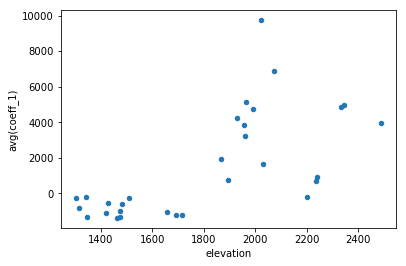

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [12]:
feature='res_1'
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

SELECT station, latitude,longitude,elevation,res_1 FROM weather


(0.071412610213615182, 1.0729421539773598)

In [13]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=3, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4 
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1500*np.sqrt(_count+0.0)), weight=1,
            color='#000', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

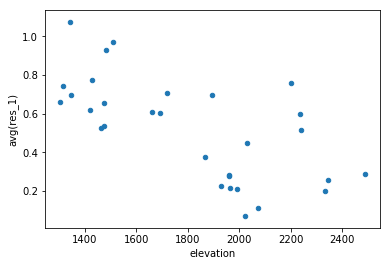

In [14]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(res_1)');

In [12]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'/PRCP_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()

['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [13]:
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.002153,-0.182283,-0.031488,-0.057910,0.084560,0.019507,0.072150,0.158679,0.061428,0.014814
1,-0.004001,-0.165204,-0.052665,-0.042697,0.057246,0.015390,0.072553,0.164065,0.047494,0.051487
2,-0.000222,-0.218895,-0.067369,0.053234,0.056157,-0.011845,-0.150262,-0.140076,-0.059782,-0.096465
3,-0.006350,-0.154621,-0.076194,0.102126,0.034991,-0.006969,-0.176686,-0.267010,-0.202524,0.122716
4,-0.018138,-0.181790,-0.110199,0.060141,-0.000309,-0.022727,-0.123299,-0.041521,0.046309,-0.341047


In [14]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00488209', u'USC00488830', u'USC00488889', u'USC00480228', u'USS0009F27S']


,0,1,2,3,4,5,6,7,8,9
station,,,,,,,,,,
USC00488209,-0.002153,-0.182283,-0.031488,-0.057910,0.084560,0.019507,0.072150,0.158679,0.061428,0.014814
USC00488830,-0.004001,-0.165204,-0.052665,-0.042697,0.057246,0.015390,0.072553,0.164065,0.047494,0.051487
USC00488889,-0.000222,-0.218895,-0.067369,0.053234,0.056157,-0.011845,-0.150262,-0.140076,-0.059782,-0.096465
USC00480228,-0.006350,-0.154621,-0.076194,0.102126,0.034991,-0.006969,-0.176686,-0.267010,-0.202524,0.122716
USS0009F27S,-0.018138,-0.181790,-0.110199,0.060141,-0.000309,-0.022727,-0.123299,-0.041521,0.046309,-0.341047


In [15]:
table=Eig.join(Stations,how='left')

In [16]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00488209,SHOSHONI,43.2372,-108.1097,1474.3,-0.002153,-0.182283,-0.031488,-0.057910
USC00488830,TECKLA 3 E,43.5833,-105.2833,1457.9,-0.004001,-0.165204,-0.052665,-0.042697
USC00488889,THERMOPOLIS 27 WNW,43.7167,-108.7500,1795.9,-0.000222,-0.218895,-0.067369,0.053234
USC00480228,ANCHOR DAM,43.6667,-108.8333,1969.9,-0.006350,-0.154621,-0.076194,0.102126


In [17]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [19]:
min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly
m

In [ ]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [ ]:
#sc.stop()